Import libraries and check TF version.

In [1]:
# TensorFlow Library
%tensorflow_version 1.x
import tensorflow as tf

# Feature Engineering Library
from sklearn.impute import SimpleImputer

# Helper Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


Get dataset from Github repo and load it to Pandas.

In [0]:
DS_TRAINING_URL = 'https://raw.githubusercontent.com/dewasathya/Bangkit-05-W05/master/titanic-extended/train.csv'
DS_TEST_URL = 'https://raw.githubusercontent.com/dewasathya/Bangkit-05-W05/master/titanic-extended/test.csv'

train_data = pd.read_csv(DS_TRAINING_URL)
test_data = pd.read_csv(DS_TEST_URL)

#train_data

Filling empty cells with values.


In [0]:
# Feature Engineering
def nan_padding(data, columns):
  for column in columns:
    imputer = SimpleImputer()
    data[column] = imputer.fit_transform(data[column].values.reshape(-1, 1))
  return data

nan_columns = ["Age", "SibSp", "Parch"]
train_data = nan_padding(train_data, nan_columns)
test_data = nan_padding(test_data, nan_columns)

Saving Passenger ID for final result.

In [0]:
# Save PassengerId for evaluation
test_passenger_id = test_data["PassengerId"]

Dropping unnecessary columns from training and test dataset.

In [0]:
# Drop not needed columns
def drop_not_concerned(data, columns):
  return data.drop(columns, axis=1)

not_concerned_columns = [
                         "PassengerId", "Name", "Ticket", "Fare",
                         "Cabin", "Embarked", "WikiId", "Name_wiki",
                         "Age_wiki", "Hometown", "Boarded", "Destination",
                         "Lifeboat", "Body", "Class"
]
train_data = drop_not_concerned(train_data, not_concerned_columns)
test_data = drop_not_concerned(test_data, not_concerned_columns)

In [6]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0.0,3,male,22.0,1.0,0.0
1,1.0,1,female,38.0,1.0,0.0
2,1.0,3,female,26.0,0.0,0.0
3,1.0,1,female,35.0,1.0,0.0
4,0.0,3,male,35.0,0.0,0.0


In [7]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,male,34.5,0.0,0.0
1,3,female,47.0,1.0,0.0
2,2,male,62.0,0.0,0.0
3,3,male,27.0,0.0,0.0
4,3,female,22.0,1.0,1.0


Separate Pclass into 3 (Pclass_1, Pclass_2, Pclass_3).

In [0]:
def dummy_data(data, columns):
  for column in columns:
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
    data = data.drop(column, axis=1)
  return data

dummy_columns = ["Pclass"]
train_data=dummy_data(train_data, dummy_columns)
test_data=dummy_data(test_data, dummy_columns)

In [9]:
test_data.head()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
0,male,34.5,0.0,0.0,0,0,1
1,female,47.0,1.0,0.0,0,0,1
2,male,62.0,0.0,0.0,0,1,0
3,male,27.0,0.0,0.0,0,0,1
4,female,22.0,1.0,1.0,0,0,1


Transform sex to number. Male = 0, Female = 1.

In [10]:
from sklearn.preprocessing import LabelEncoder

def sex_to_int(data):
  le = LabelEncoder()
  le.fit(["male","female"])
  data["Sex"]=le.transform(data["Sex"]) 
  return data

train_data = sex_to_int(train_data)
test_data = sex_to_int(test_data)
train_data.head()

,Survived,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
0,0.0,1,22.0,1.0,0.0,0,0,1
1,1.0,0,38.0,1.0,0.0,1,0,0
2,1.0,0,26.0,0.0,0.0,0,0,1
3,1.0,0,35.0,1.0,0.0,1,0,0
4,0.0,1,35.0,0.0,0.0,0,0,1


Normalize passenger's age.

In [11]:
from sklearn.preprocessing import MinMaxScaler

def normalize_age(data):
  scaler = MinMaxScaler()
  data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
  return data
  
train_data = normalize_age(train_data)
test_data = normalize_age(test_data)
train_data.head()

,Survived,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
0,0.0,1,0.271174,1.0,0.0,0,0,1
1,1.0,0,0.472229,1.0,0.0,1,0,0
2,1.0,0,0.321438,0.0,0.0,0,0,1
3,1.0,0,0.434531,1.0,0.0,1,0,0
4,0.0,1,0.434531,0.0,0.0,0,0,1


In [12]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

def split_valid_test_data(data, fraction=(1 - 0.8)):
  data_y = data["Survived"]
  lb = LabelBinarizer()
  data_y = lb.fit_transform(data_y)

  data_x = data.drop(["Survived"], axis=1)

  train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=fraction)

  return train_x.values, train_y, valid_x, valid_y

train_x, train_y, valid_x, valid_y = split_valid_test_data(train_data)
print("train_x:{}".format(train_x.shape))
print("train_y:{}".format(train_y.shape))
print("train_y content:{}".format(train_y[:3]))

print("valid_x:{}".format(valid_x.shape))
print("valid_y:{}".format(valid_y.shape))

train_x:(712, 7)
train_y:(712, 1)
train_y content:[[0]
 [0]
 [1]]
valid_x:(179, 7)
valid_y:(179, 1)


Build the neural network.

In [13]:
# Build Neural Network
from collections import namedtuple

def build_neural_network(hidden_units=10):
  tf.reset_default_graph()
  inputs = tf.placeholder(tf.float32, shape=[None, train_x.shape[1]])
  labels = tf.placeholder(tf.float32, shape=[None, 1])
  learning_rate = tf.placeholder(tf.float32)
  is_training=tf.Variable(True,dtype=tf.bool)

  initializer = tf.contrib.layers.xavier_initializer()
  fc = tf.layers.dense(inputs, hidden_units, activation=None,kernel_initializer=initializer)
  fc=tf.layers.batch_normalization(fc, training=is_training)
  fc=tf.nn.relu(fc)

  logits = tf.layers.dense(fc, 1, activation=None)
  cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
  cost = tf.reduce_mean(cross_entropy)

  with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

  predicted = tf.nn.sigmoid(logits)
  correct_pred = tf.equal(tf.round(predicted), labels)
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

  # Export the nodes 
  export_nodes = ['inputs', 'labels', 'learning_rate','is_training', 'logits',
                  'cost', 'optimizer', 'predicted', 'accuracy']
  Graph = namedtuple('Graph', export_nodes)
  local_dict = locals()
  graph = Graph(*[local_dict[each] for each in export_nodes])

  return graph

model = build_neural_network()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def get_batch(data_x,data_y,batch_size=32):
  batch_n=len(data_x)//batch_size
  for i in range(batch_n):
    batch_x=data_x[i*batch_size:(i+1)*batch_size]
    batch_y=data_y[i*batch_size:(i+1)*batch_size]
    
    yield batch_x,batch_y

In [15]:
epochs = 200
train_collect = 50
train_print=train_collect*2

learning_rate_value = 0.001
batch_size=16

x_collect = []
train_loss_collect = []
train_acc_collect = []
valid_loss_collect = []
valid_acc_collect = []

saver = tf.train.Saver()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  iteration=0
  for e in range(epochs):
    for batch_x,batch_y in get_batch(train_x,train_y,batch_size):
      iteration+=1
      feed = {model.inputs: train_x, 
              model.labels: train_y, 
              model.learning_rate: learning_rate_value, 
              model.is_training:True}

      train_loss, _, train_acc = sess.run([model.cost, model.optimizer, model.accuracy], feed_dict=feed)
      
      if iteration % train_collect == 0:
        ##
        x_collect.append(e)
        train_loss_collect.append(train_loss)
        train_acc_collect.append(train_acc)

        if iteration % train_print==0:
          ##
          print("Epoch: {}/{}".format(e + 1, epochs),
          "Train Loss: {:.4f}".format(train_loss),
          "Train Acc: {:.4f}".format(train_acc))
                
        feed = {model.inputs: valid_x,
                model.labels: valid_y,
                model.is_training:False}
        val_loss, val_acc = sess.run([model.cost, model.accuracy], feed_dict=feed)
        valid_loss_collect.append(val_loss)
        valid_acc_collect.append(val_acc)
        
        if iteration % train_print==0:
          ##
          print("Epoch: {}/{}".format(e + 1, epochs), 
                "Validation Loss: {:.4f}".format(val_loss), 
                "Validation Acc: {:.4f}".format(val_acc))
  
  saver.save(sess, "./titanic.ckpt")

Epoch: 3/200 Train Loss: 0.5115 Train Acc: 0.7837
Epoch: 3/200 Validation Loss: 0.5900 Validation Acc: 0.7263
Epoch: 5/200 Train Loss: 0.4454 Train Acc: 0.8174
Epoch: 5/200 Validation Loss: 0.5072 Validation Acc: 0.7709
Epoch: 7/200 Train Loss: 0.4216 Train Acc: 0.8188
Epoch: 7/200 Validation Loss: 0.4598 Validation Acc: 0.7709
Epoch: 10/200 Train Loss: 0.4130 Train Acc: 0.8216
Epoch: 10/200 Validation Loss: 0.4426 Validation Acc: 0.7989
Epoch: 12/200 Train Loss: 0.4095 Train Acc: 0.8244
Epoch: 12/200 Validation Loss: 0.4375 Validation Acc: 0.7877
Epoch: 14/200 Train Loss: 0.4074 Train Acc: 0.8216
Epoch: 14/200 Validation Loss: 0.4368 Validation Acc: 0.7877
Epoch: 16/200 Train Loss: 0.4059 Train Acc: 0.8216
Epoch: 16/200 Validation Loss: 0.4367 Validation Acc: 0.7821
Epoch: 19/200 Train Loss: 0.4050 Train Acc: 0.8258
Epoch: 19/200 Validation Loss: 0.4350 Validation Acc: 0.7989
Epoch: 21/200 Train Loss: 0.4041 Train Acc: 0.8244
Epoch: 21/200 Validation Loss: 0.4350 Validation Acc: 0.798

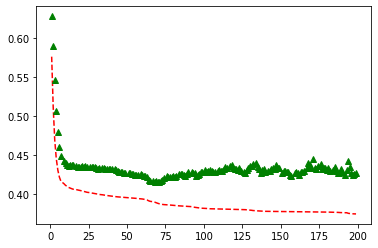

In [16]:
plt.plot(x_collect, train_loss_collect, "r--")
plt.plot(x_collect, valid_loss_collect, "g^")
plt.show()

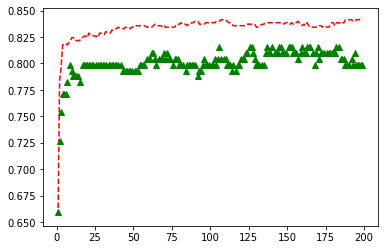

In [17]:
plt.plot(x_collect, train_acc_collect, "r--")
plt.plot(x_collect, valid_acc_collect, "g^")
plt.show()

In [18]:
model=build_neural_network()
restorer=tf.train.Saver()
with tf.Session() as sess:
  restorer.restore(sess,"./titanic.ckpt")
  feed={
      model.inputs:test_data,
      model.is_training:False
  }
  test_predict=sess.run(model.predicted,feed_dict=feed)

test_predict[:10]

INFO:tensorflow:Restoring parameters from ./titanic.ckpt


array([[0.11659506],
       [0.40112156],
       [0.02048436],
       [0.14087674],
       [0.3593511 ],
       [0.13242844],
       [0.6147425 ],
       [0.15695527],
       [0.6183718 ],
       [0.17176211]], dtype=float32)

In [19]:
from sklearn.preprocessing import Binarizer
binarizer=Binarizer(0.5)
test_predict_result=binarizer.fit_transform(test_predict)
test_predict_result=test_predict_result.astype(np.int32)
test_predict_result[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]], dtype=int32)

In [20]:
passenger_id=test_passenger_id.copy()
evaluation=passenger_id.to_frame()
evaluation["Survived"]=test_predict_result
evaluation[:10]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [0]:
evaluation.to_csv("evaluation_submission.csv",index=False)